# Association Rule Mining for reported Crimes in England
The aim here is to see if there are any associations between the reported aspects of crime, such as Month of Year, Location, Crime type etc.
This will be done in Pyspark due to the size of the data but it will still be possible to execute on a local cluster.

The data can be downloaded from here: https://data.police.uk/data/.

The date range for this data is September 2015 - August 2018 and all constabularies in England were selected (excluding British Transport Police)

## What is an Association Rule?
*Association rule learning is a rule-based machine learning method for discovering interesting relations between variables in large databases. It is intended to identify strong rules discovered in databases using some measures of interestingness. This rule-based approach also generates new rules as it analyzes more data. The ultimate goal, assuming a large enough dataset, is to help a machine mimic the human brain’s feature extraction and abstract association capabilities from new uncategorized data.*

We will be looking for rules with a high level of confidence

*Confidence is an indication of how often the rule has been found to be true... Confidence can be interpreted as an estimate of the conditional probability*

In [1]:
import glob
import os
import calendar
import pandas as pd
import matplotlib.pyplot as plt

#### Set up Spark
Running Spark locally

In [2]:
from pyspark import SparkContext
from pyspark.ml.fpm import FPGrowth
from pyspark.sql import SQLContext, SparkSession

In [3]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Crime Assocations")\
        .getOrCreate()

In [4]:
sc = spark.sparkContext
# Set up a SQL Context
sqlCtx = SQLContext(sc)

In [25]:
#sc.stop()

## Load Data into Spark

In [5]:
import pyspark.sql.functions as F

The police data comes in several csv files with a folder for each Month-Year. Within each folder, there is a CSV file for each constabulary. We will concatenate these

In [6]:
# Using a glob here to get all of the locations of the files we need
file_locations = glob.glob(os.getcwd() + "/all_data/*/*.csv")

In [7]:
police_data_df = sqlCtx.read.format("csv").option("header", "true").load(file_locations)

#### Inspecting the data

In [9]:
police_data_df.show(5)

+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|            Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|5ac3055389bf0d7f7...|2017-07|Metropolitan Poli...|Metropolitan Poli...| 0.763024|51.210698|On or near Wind H...|E01024033|        Ashford 002E|         Other theft| Investigation com...|   null|
|db2ba97b31d87e77e...|2017-07|Metropolitan Poli...|Metropolitan Poli...| 1.185594|52.000179|On or near Main Road|E01029873|        Babergh 011B|        Public order| Investigation com...|   null|
|                nul

Each dataset contains the following columns:

In [10]:
police_data_df.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



The Data Dictionary is as follows

In [40]:
dictionary = pd.read_csv('data_dictionary.csv')

In [45]:
pd.set_option('display.max_colwidth', -1)
dictionary

,Field,Meaning
0,Reported by,The force that provided the data about the crime.
1,Falls within,"At present, also the force that provided the data about the crime. This is currently being looked into and is likely to change in the near future."
2,Longitude and Latitude,The anonymised coordinates of the crime. See Location Anonymisation for more information.
3,LSOA code and LSOA name,"References to the Lower Layer Super Output Area that the anonymised point falls into, according to the LSOA boundaries provided by the Office for National Statistics."
4,Crime type,One of the crime types listed in the Police.UK FAQ.
5,Last outcome category,"A reference to whichever of the outcomes associated with the crime occurred most recently. For example, this crime's 'Last outcome category' would be 'Formal action is not in the public interest'."
6,Context,"A field provided for forces to provide additional human-readable data about individual crimes. Currently, for newly added CSVs, this is always empty."


NOTE: LSOA (Lower Layer Super Output Area)

From NHS Data Dictionary (https://www.datadictionary.nhs.uk/data_dictionary/nhs_business_definitions/l/lower_layer_super_output_area_de.asp?shownav=1)
    
"<i>A Lower Layer Super Output Area (LSOA) is a GEOGRAPHIC AREA.
Lower Layer Super Output Areas are a geographic hierarchy designed to improve the reporting of small area statistics in England and Wales.
Lower Layer Super Output Areas are built from groups of contiguous Output Areas and have been automatically generated to be as consistent in population size as possible, and typically contain from four to six Output Areas. The Minimum population is 1000 and the mean is 1500.
There is a Lower Layer Super Output Area for each POSTCODE in England and Wales</i>"

How many Rows do we have?

In [13]:
num_rows = police_data_df.count()

In [14]:
num_rows

18376429

## Cleaning the Data

In [8]:
# The month column in the data is actually a Year-Month, here we will split that on the - delimiter and create a Year and Month_of_Year Column
month_year_split = F.split(police_data_df['Month'], '-')
police_data_df = police_data_df.withColumn('Year', month_year_split.getItem(0))\
                .withColumn('Month_of_Year', month_year_split.getItem(1))

In [9]:
# Ensure that both of the new columns created are integer and not string types
police_data_df = police_data_df.withColumn("Month_of_Year", police_data_df.Month_of_Year.cast("int"))
police_data_df = police_data_df.withColumn("Year", police_data_df.Year.cast("int"))

In [10]:
# Check this worked
police_data_df.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month_of_Year: integer (nullable = true)



In [11]:
# In order to convert the month from a number representing the month index, this function has been created to map that index
# to its 3 letter abbreviation
get_month_name = F.udf(lambda x: calendar.month_abbr[x])

In [12]:
# Apply get_month_name to the Month of Year Column
police_data_df = police_data_df.withColumn("Month_of_Year", get_month_name(police_data_df["Month_of_Year"]))

In [13]:
# Now remove the On or near part of the string in Location as it adds no information
police_data_df = police_data_df.withColumn('Location', F.regexp_replace('Location', 'On or near ', ''))

In [14]:
police_data_df = police_data_df.withColumn("Town_City", F.regexp_replace('LSOA name', ' [0-9]{3}\w', ''))

In [15]:
police_data_df.take(1)

[Row(Crime ID='5ac3055389bf0d7f7598892a8835ce3b3a2745218bde6f9d16de014ee837ec1e', Month='2017-07', Reported by='Metropolitan Police Service', Falls within='Metropolitan Police Service', Longitude='0.763024', Latitude='51.210698', Location='Wind Hill Lane', LSOA code='E01024033', LSOA name='Ashford 002E', Crime type='Other theft', Last outcome category='Investigation complete; no suspect identified', Context=None, Year=2017, Month_of_Year='Jul', Town_City='Ashford')]

## Exploratory Analysis

#### Number of Incidents over time

In [23]:
crime_over_time = police_data_df\
                 .groupBy(["Month_of_Year", "Year"])\
                 .count()\
                 .toPandas()

In [39]:
months = map(lambda x: calendar.month_abbr[x], range(1, 13))
crime_over_time["Month_of_Year"] = pd.Categorical(crime_over_time["Month_of_Year"], categories=months)
crime_time_series = crime_over_time.set_index(["Year", "Month_of_Year"]).sort_index().squeeze()

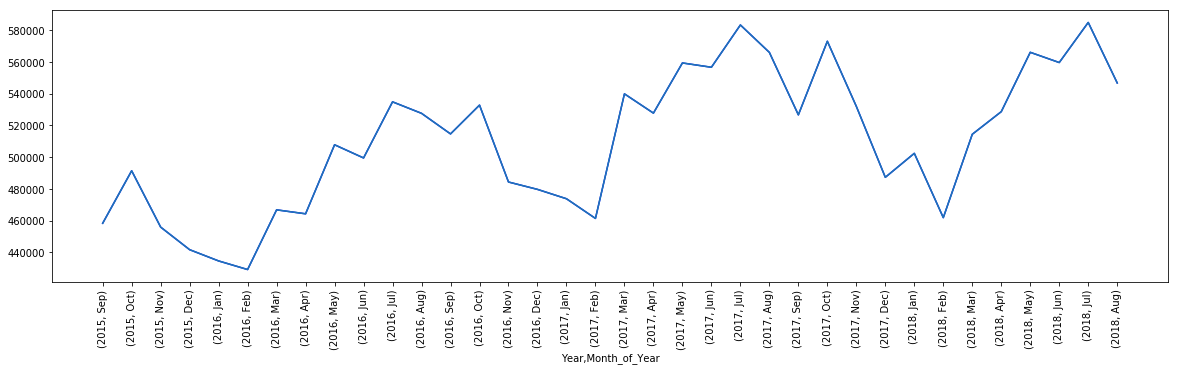

In [49]:
plt.figure(figsize=(20, 5))
ax = crime_time_series.plot(kind = "line", color="b")
ax.set_xticks(range(0, len(crime_time_series.index)))
ax.set_xticklabels(list(crime_time_series.index))
crime_time_series.plot(rot=90)
plt.show()

In [ ]:
There isn'

#### Most Common Crime and Outcome Category Combination

In [24]:
outcome_counts = police_data_df\
                 .groupBy(["Crime type", "Last outcome category"])\
                 .count()\
                 .toPandas()

In [31]:
outcome_counts_series = outcome_counts\
.set_index(["Crime type", "Last outcome category"])\
.squeeze()\
.sort_values(ascending=False)\
.head(20)

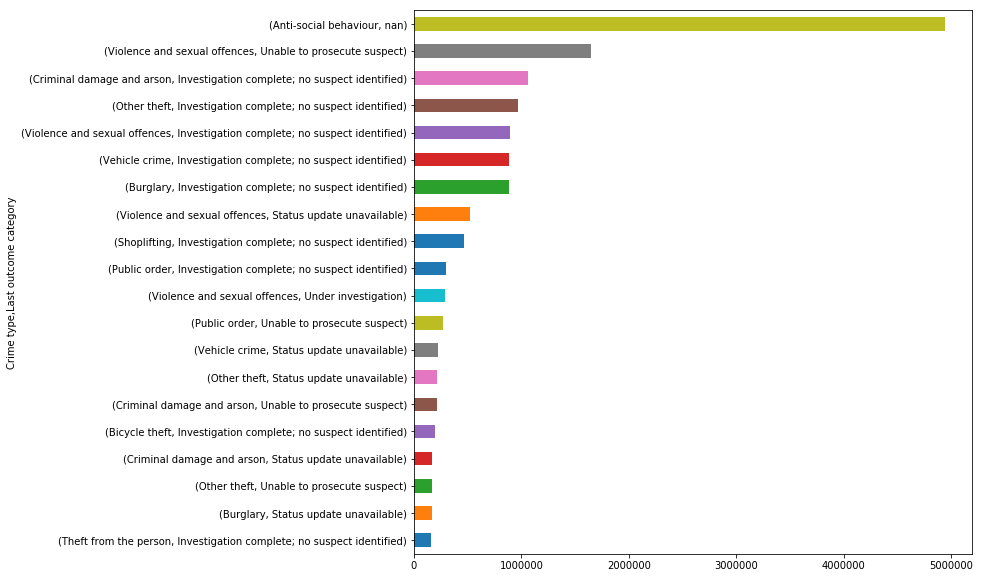

In [34]:
outcome_counts_series\
.sort_values(ascending=True)\
.plot(kind="barh", figsize=(10,10))

#### The Most Common Type of Crime

In [202]:
crime_type_counts = police_data_df\
                    .groupBy(police_data_df['Crime type'])\
                    .count()\
                    .sort(F.col("count").desc())\
                    .toPandas()

In [218]:
crime_type_counts_series = crime_type_counts.set_index("Crime type").squeeze()
crime_type_counts_series = crime_type_counts_series*100/num_rows

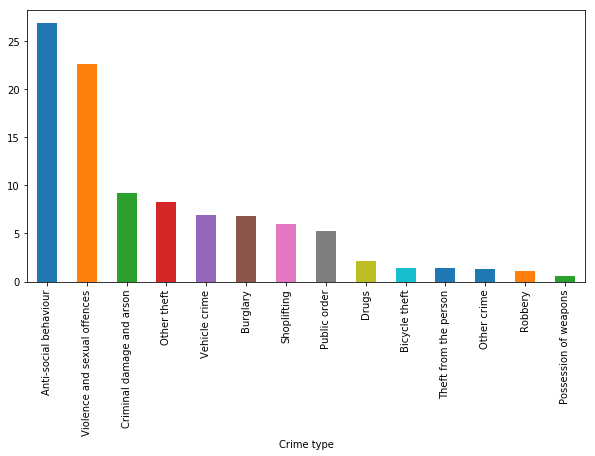

In [219]:
plt.figure(figsize=(10, 5))
crime_type_counts_series.plot(kind = "bar")
plt.show()

Anti-social behaviour makes up about 27% of crime in England - which is expected... It is concerning that violence and sexual offences is in second place

#### Which Town or City has the most crime?

In [36]:
crime_town_city_counts = police_data_df\
                    .groupBy(police_data_df['Town_City'])\
                    .count()\
                    .sort(F.col("count").desc())\
                    .toPandas()

In [ ]:
crime_town_city_counts ## TO BE COMPLETED

There appear to be a large amount of NAs....
Lets find out what the NAs are being caused by

In [279]:
null_lsoa = police_data_df\
                    .where(police_data_df["LSOA name"].isNull())

In [289]:
null_lsoa.count()/num_rows

0.018709130049151552

So only about two percent of the data has no location information, we can exclude this

## Feature Engineering & Modelling

In [16]:
# Remove the crimes with no crime ID and no LSOA Information.
police_data_modelling = police_data_df.filter(police_data_df["Crime ID"].isNotNull() & police_data_df["LSOA name"].isNotNull())
# Select the Features of interest
police_data_modelling = police_data_modelling[["Falls within", "Town_City", "Crime type", "Last outcome category", "Month_of_Year"]]

In [42]:
police_data_modelling.show(3)

+--------------------+--------------------+-------------+---------------------+-------------+
|        Falls within|           Town_City|   Crime type|Last outcome category|Month_of_Year|
+--------------------+--------------------+-------------+---------------------+-------------+
|Metropolitan Poli...|             Ashford|  Other theft| Investigation com...|          Jul|
|Metropolitan Poli...|             Babergh| Public order| Investigation com...|          Jul|
|Metropolitan Poli...|Barking and Dagenham|Bicycle theft| Status update una...|          Jul|
+--------------------+--------------------+-------------+---------------------+-------------+
only showing top 3 rows



The FP growth algorithm (like association rules), needs the items to be concatenated into a list/array of "transactions".

In [17]:
police_item_set = police_data_modelling.withColumn("items", F.array(police_data_modelling["Falls within"],
                                                                    police_data_modelling["Town_City"],
                                                                    police_data_modelling["Crime type"],
                                                                    police_data_modelling["Last outcome category"],
                                                                    police_data_modelling["Month_of_Year"]))
police_item_set = police_item_set.select("items")
police_item_set = police_item_set.withColumn("id", F.monotonically_increasing_id())

In [44]:
police_item_set.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------+---+
|items                                                                                                                                |id |
+-------------------------------------------------------------------------------------------------------------------------------------+---+
|[Metropolitan Police Service, Ashford, Other theft, Investigation complete; no suspect identified, Jul]                              |0  |
|[Metropolitan Police Service, Babergh, Public order, Investigation complete; no suspect identified, Jul]                             |1  |
|[Metropolitan Police Service, Barking and Dagenham, Bicycle theft, Status update unavailable, Jul]                                   |2  |
|[Metropolitan Police Service, Barking and Dagenham, Burglary, Investigation complete; no suspect identified, Jul]                    |3  |
|[Metropolitan Polic

## Modelling: Create the FP growth algorithm
For Association rules

In [23]:
# Use a low support as we have a large dataset
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.01, minConfidence=0.6)
model = fpGrowth.fit(police_item_set)
rules = model.associationRules

#### Extract the Association Rules

In [24]:
#' Minor tidying to save as pandas dataframe
rules_df = rules.withColumn("antecedent" ,F.concat_ws(",", rules["antecedent"]))\
          .withColumn("consequent" ,F.concat_ws(",", rules["consequent"]))\
          .sort(F.col("confidence"))

In [25]:
rules_df_pd = rules_df.toPandas()

In [26]:
rules_df_pd

,antecedent,consequent,confidence
0,Birmingham,Investigation complete; no suspect identified,0.605648
1,"Birmingham,West Midlands Police",Investigation complete; no suspect identified,0.606086
2,"West Yorkshire Police,Unable to prosecute suspect",Violence and sexual offences,0.607760
3,"Apr,Unable to prosecute suspect",Violence and sexual offences,0.617650
4,"Mar,Unable to prosecute suspect",Violence and sexual offences,0.621251
5,Unable to prosecute suspect,Violence and sexual offences,0.621682
6,"Jul,Unable to prosecute suspect",Violence and sexual offences,0.621848
7,"May,Unable to prosecute suspect",Violence and sexual offences,0.622494
8,"Jun,Unable to prosecute suspect",Violence and sexual offences,0.623000
9,Criminal damage and arson,Investigation complete; no suspect identified,0.626508


In [28]:
rules_df_pd.to_csv('crime_associations.csv')

In [29]:
# Stop the Spark Session
sc.stop()

## Rules Analysis
As you can see, the rules in the 98%+ confidence region appear to be rules that don't really tell us anything. i.e. Birmingham -> West Midlands Police. Let's remove those from the analysis

In [37]:
useful_rules_df = rules_df_pd[rules_df_pd['confidence'] < 0.98]\
    .sort_values(by="confidence", ascending = False)

In [38]:
useful_rules_df

,antecedent,consequent,confidence
16,"Vehicle crime,Status update unavailable",Metropolitan Police Service,0.774634
15,Bicycle theft,Investigation complete; no suspect identified,0.726171
14,Burglary,Investigation complete; no suspect identified,0.705977
13,Vehicle crime,Investigation complete; no suspect identified,0.702534
12,Other theft,Investigation complete; no suspect identified,0.644389
11,"Manchester,Greater Manchester Police",Investigation complete; no suspect identified,0.641596
10,Manchester,Investigation complete; no suspect identified,0.641456
9,Criminal damage and arson,Investigation complete; no suspect identified,0.626508
8,"Jun,Unable to prosecute suspect",Violence and sexual offences,0.623000
7,"May,Unable to prosecute suspect",Violence and sexual offences,0.622494


Now the rule with the highest confidence is **(Vehicle Crime + Status update unavailable -> Metropolitan Police Service)**. So what does this mean? This means that 77% of the time, when a Vehicle Crime occured that has no Status update about its outcome, it fell within the jurisdiction of the Metropolitan Police.

The other 3 rules in the 70%+ confidence/conditional probability region follow a similar pattern.
- **(Bicycle Theft -> Investigation complete; no suspect identified)**
- **(Burglary -> Investigation complete; no suspect identified)**
- **(Vehicle Crime -> Investigation complete; no suspect identified)**

So, it implies that the probability of no suspect being identified after a bike theft, burglary or vehicle crime is about 70-72%.

Another interesting rule is **(Manchester -> Investigation complete; no suspect identified)** with a probability of 64%. Good thing I have never been to Manchester!

Another block of these rules is **(Unable to prosecute suspect -> Violence and sexual offences)**, which sounds worrying but doesn't really say much. The conditional probability of a crime being a violence and sexual offence, given that you were unable to prosecute the suspect is around 62%.